In [38]:
# Import Necessary Packages / Libraries
# Do manipulation and analysis of the data
import pandas as pd
# Provide functions for interacting with the opearting system
import os
# To save and load the machine learning models with scikit-learn
import joblib
# Resize/Gratscale conversion/Threshold/Noiceless/HOG
from ipynb.fs.full.preprocessing_image import preprocessing_img
# Get the dataset directory
from pathlib import Path
# Normalize labels (y), transform non-numerical labels to numerical labels
# Encode tagert labels with the value between 0 to n_classes-1.
from sklearn.preprocessing import LabelEncoder
# a set of decision trees (DT) from a randomly selected subset of 
# the training set and then It collects the votes from different decision trees 
# to decide the final prediction.
from sklearn.ensemble import RandomForestClassifier
# Classifier implementing the k-nearest neighbors vote
from sklearn.neighbors import KNeighborsClassifier
# To evaluate the accuracy of a classification
from sklearn.metrics import confusion_matrix
# Xgboost stands for eXtreme Gradient Boosting
# It developed on the framework of gradient boosting
from xgboost import XGBClassifier

In [2]:
def prediction_result(test_Y, pred_Y):
    # compute the confusion matrix and and use it to derive the raw
    # accuracy, sensitivity, and specificity
    cm = confusion_matrix(test_Y, pred_Y)
    (tn, fp, fn, tp) = cm.flatten()

    # calculate accuracy
    conf_matrix_accuracy = (float (tp + tn) / float(tp + tn + fp + fn))

    # calculate misclassification
    conf_matrix_misclassification = 1- conf_matrix_accuracy

    # calculate the sensitivity
    conf_matrix_sensitivity = (tp / float(tp + fn))

    # calculate the specificity
    conf_matrix_specificity = (tn / float(tn + fp))

    # calculate precision
    conf_matrix_precision = (tp / float(tp + fp))

    # calculate f_1 score
    conf_matrix_f1 = 2 * ((conf_matrix_precision * conf_matrix_sensitivity) / 
                          (conf_matrix_precision + conf_matrix_sensitivity))

    print('-'*55)
    print(f'Accuracy         : {round(conf_matrix_accuracy, 2)}') 
    print(f'Misclassification: {round(conf_matrix_misclassification, 2)}') 
    print(f'Sensitivity      : {round(conf_matrix_sensitivity, 2)}') 
    print(f'Specificity      : {round(conf_matrix_specificity, 2)}') 
    print(f'Precision        : {round(conf_matrix_precision, 2)}')
    print(f'f1-Score         : {round(conf_matrix_f1, 2)}')
    print('-'*55)

    # Assigning columns names
    cm_df = pd.DataFrame(cm, 
                         columns = ['Predicted Negative', 'Predicted Positive'],
                         index = ['Actual Negative', 'Actual Positive'])

    print(cm_df)

In [3]:
dataset_dir = Path('dataset').resolve()
dicts_temp = {}
df_dataset = pd.DataFrame(columns=['file_path'])

for path, subdirs, files in os.walk(dataset_dir):
    for filename in files:
        if filename.endswith('.png'):
            dicts_temp['file_path'] = Path(os.path.join(path, filename))
            df_temp = pd.DataFrame([dicts_temp])
            df_dataset = pd.concat([df_dataset, df_temp], ignore_index=True)

df_dataset['image_code']    = df_dataset['file_path'].map(lambda x: x.stem)
df_dataset['disease']       = df_dataset['file_path'].map(lambda x: x.parent.stem)
df_dataset['validation']    = df_dataset['file_path'].map(lambda x: x.parent.parent.stem)
df_dataset['geometry_type'] = df_dataset['file_path'].map(lambda x: x.parent.parent.parent.stem)

df_dataset.sample(3)

,file_path,image_code,disease,validation,geometry_type
47,C:\Users\ZHENGYU\Desktop\P2\dataset\spiral\tra...,V09HE03,healthy,training,spiral
23,C:\Users\ZHENGYU\Desktop\P2\dataset\spiral\tes...,V07PE01,parkinson,testing,spiral
6,C:\Users\ZHENGYU\Desktop\P2\dataset\spiral\tes...,V07HE01,healthy,testing,spiral


[INFO] loading data...


training data load:   0%|          | 0/72 [00:00<?, ?it/s]

testing data load:   0%|          | 0/30 [00:00<?, ?it/s]

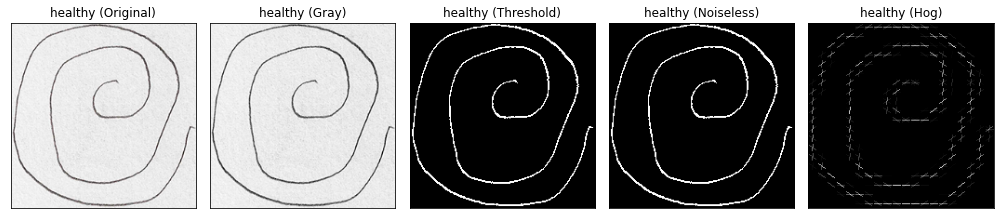

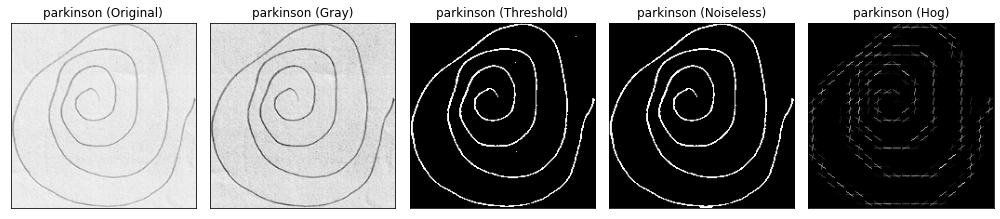

In [4]:
# loading the training and testing data
print("[INFO] loading data...")
(train_X, train_Y) = preprocessing_img(df_dataset.loc[(df_dataset['validation'] == 'training') 
                                                      & (df_dataset['geometry_type'] == 'spiral')], False)
(test_X, test_Y) = preprocessing_img(df_dataset.loc[(df_dataset['validation'] == 'testing') 
                                                    & (df_dataset['geometry_type'] == 'spiral')], True)

In [5]:
print("Features Result")
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

Features Result
(72, 12996)
(72,)
(30, 12996)
(30,)


In [14]:
# encode the labels as integers
le = LabelEncoder()
trainX = train_X
trainY = le.fit_transform(train_Y)
testX = test_X
testY = le.transform(test_Y)

models = {
    "Rf": {
        "classifier": RandomForestClassifier(n_estimators=100),
        "accuracy": 0,
        "sensitivity": 0,
        "specificity": 0,
    },
    "Xgb": {
        "classifier": XGBClassifier(),
        "accuracy": 0,
        "sensitivity": 0,
        "specificity": 0,
    },
    "KNN": {
        "classifier": KNeighborsClassifier(n_neighbors=7),
        "accuracy": 0,
        "sensitivity": 0,
        "specificity": 0,
    }
}

for model in models:
    print(model)
    models[model]["classifier"].fit(trainX, trainY)
    predY = models[model]["classifier"].predict(testX)
    prediction_result(testY, predY)
    print('\r\n')

Rf
-------------------------------------------------------
Accuracy         : 0.87
Misclassification: 0.13
Sensitivity      : 0.8
Specificity      : 0.93
Precision        : 0.92
f1-Score         : 0.86
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                  14                   1
Actual Positive                   3                  12


Xgb
-------------------------------------------------------
Accuracy         : 0.8
Misclassification: 0.2
Sensitivity      : 0.73
Specificity      : 0.87
Precision        : 0.85
f1-Score         : 0.79
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                  13                   2
Actual Positive                   4                  11


KNN
-------------------------------------------------------
Accuracy         : 0.7
Misclassification: 0.3
Sensitivity      : 0.73
Specificity   

In [19]:
# Save the model as a pickle in a file
joblib.dump(models['Rf']["classifier"], './model/finalized_spiral_model.joblib', compress=True)

print("Spiral Prediction Result:")
predY = models['Rf']["classifier"].predict(testX)
prediction_result(testY, predY)

Spiral Prediction Result:
-------------------------------------------------------
Accuracy         : 0.87
Misclassification: 0.13
Sensitivity      : 0.8
Specificity      : 0.93
Precision        : 0.92
f1-Score         : 0.86
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                  14                   1
Actual Positive                   3                  12


[INFO] loading data...


training data load:   0%|          | 0/72 [00:00<?, ?it/s]

testing data load:   0%|          | 0/30 [00:00<?, ?it/s]

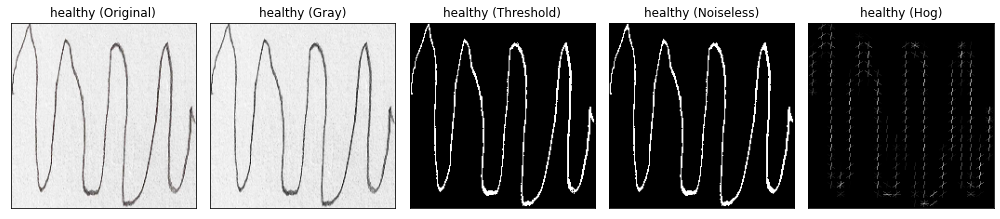

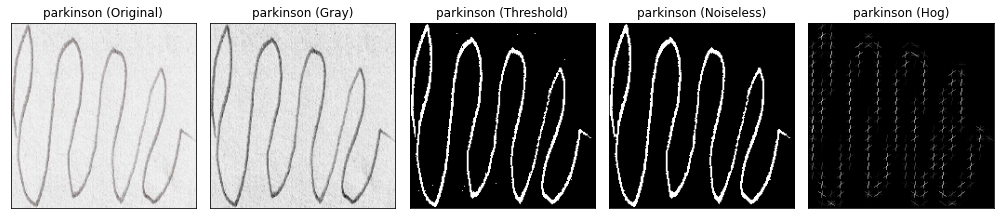

In [20]:
# loading the training and testing data
print("[INFO] loading data...")
(train_X, train_Y) = preprocessing_img(df_dataset.loc[(df_dataset['validation'] == 'training') & (df_dataset['geometry_type'] == 'wave')], False)
(test_X, test_Y) = preprocessing_img(df_dataset.loc[(df_dataset['validation'] == 'testing') & (df_dataset['geometry_type'] == 'wave')], True)

In [21]:
print("Features Result")
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

Features Result
(72, 12996)
(72,)
(30, 12996)
(30,)


In [28]:
# encode the labels as integers
le = LabelEncoder()
trainX = train_X
trainY = le.fit_transform(train_Y)
testX = test_X
testY = le.transform(test_Y)

models = {
    "Rf": {
        "classifier": RandomForestClassifier(n_estimators=100),
        "accuracy": 0,
        "sensitivity": 0,
        "specificity": 0,
    },
    "Xgb": {
        "classifier": XGBClassifier(),
        "accuracy": 0,
        "sensitivity": 0,
        "specificity": 0,
    },
    "KNN": {
        "classifier": KNeighborsClassifier(n_neighbors=7),
        "accuracy": 0,
        "sensitivity": 0,
        "specificity": 0,
    }
}

for model in models:
    print(model)
    models[model]["classifier"].fit(trainX, trainY)
    predY = models[model]["classifier"].predict(testX)
    prediction_result(testY, predY)
    print('\r\n')

Rf
-------------------------------------------------------
Accuracy         : 0.77
Misclassification: 0.23
Sensitivity      : 0.8
Specificity      : 0.73
Precision        : 0.75
f1-Score         : 0.77
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                  11                   4
Actual Positive                   3                  12


Xgb
-------------------------------------------------------
Accuracy         : 0.6
Misclassification: 0.4
Sensitivity      : 0.67
Specificity      : 0.53
Precision        : 0.59
f1-Score         : 0.62
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                   8                   7
Actual Positive                   5                  10


KNN
-------------------------------------------------------
Accuracy         : 0.73
Misclassification: 0.27
Sensitivity      : 0.87
Specificity 

In [35]:
# Save the model as a pickle in a file
joblib.dump(models['Rf']["classifier"], './model/finalized_wave_model.joblib', compress=True)

print("Wave Prediction Result:")
predY = models['Rf']["classifier"].predict(testX)
prediction_result(testY, predY)

Wave Prediction Result:
-------------------------------------------------------
Accuracy         : 0.77
Misclassification: 0.23
Sensitivity      : 0.8
Specificity      : 0.73
Precision        : 0.75
f1-Score         : 0.77
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                  11                   4
Actual Positive                   3                  12
